In [1]:
import os
import re
import h5py
import random
import numpy as np
import pandas as pd
import scipy.io
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import utils

datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)
raster_data = pd.read_pickle('../datasets/NNN/unit_data_full.pkl')

In [2]:
raster_data['session'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59])

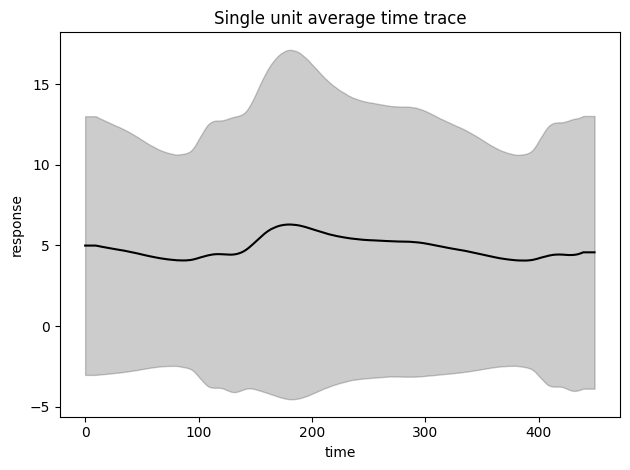

In [5]:
single_units = raster_data[raster_data['unit_type']==1]
stacked = np.stack(single_units['img_psth'])
mean_per_unit = stacked.mean(axis=2)

df_long = pd.DataFrame(mean_per_unit).melt(var_name='time', value_name='response')
df_long['unit'] = np.repeat(np.arange(mean_per_unit.shape[0]), mean_per_unit.shape[1])

plt.subplots(1,1)
sns.lineplot(data=df_long, x='time', y='response', errorbar='sd', color='black')
plt.title('Single unit average time trace')
plt.tight_layout()
plt.show()

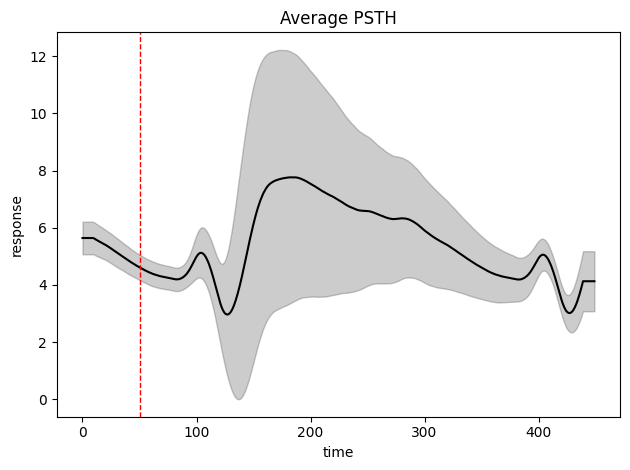

In [31]:
roi = 'MF1_8_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]

stacked = np.stack(roi_data['img_psth'])
averaged = np.mean(stacked, axis=0) # shape (450,1072)
df = pd.DataFrame(averaged)  # shape (450, 1072)
df_long = df.melt(var_name='image', value_name='response')
df_long['time'] = np.tile(np.arange(df.shape[0]), df.shape[1])



fig,ax=plt.subplots(1,1)
sns.lineplot(
    data=df_long, x='time', y='response',
    errorbar='sd',
    color='black',
    ax=ax
)
ax.axvline(x=50, color='red', linestyle='--', linewidth=1)
plt.title('Average PSTH')
plt.tight_layout()
plt.show()

[None 'MB1_3_B' 'MO2_21_O' 'Unknown_22_O' 'MB2_20_B' 'Unknown_11_O'
 'Unknown_20_B' 'MO1s1_4_O' 'Unknown_4_O' 'Unknown_6_B' 'MB2_21_B'
 'LPP4_1_O' 'Unknown_19_F' 'LPP1_2_O' 'Unknown_9_B' 'MF1_9_F'
 'Unknown_23_B' 'MB1_8_B' 'MF1_8_F' 'Unknown_15_O' 'AF3_18_F' 'AB3_18_B'
 'CLC3_13_O' 'Unknown_14_O' 'AO2_24_O' 'PITP4_10_O' 'MB3_12_B'
 'Unknown_6_O' 'MF1_7_F' 'MO1s2_5_O' 'Unknown_5_F' 'AB3_12_B'
 'Unknown_16_O' 'AB3_17_B' 'Unknown_26_O' 'Unknown_27_B' 'AO5_25_O'
 'AMC3_28_F']


In [31]:
np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)]))

array([1024, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040,
       1041, 1042, 1049, 1050, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
       1069, 1070, 1071])

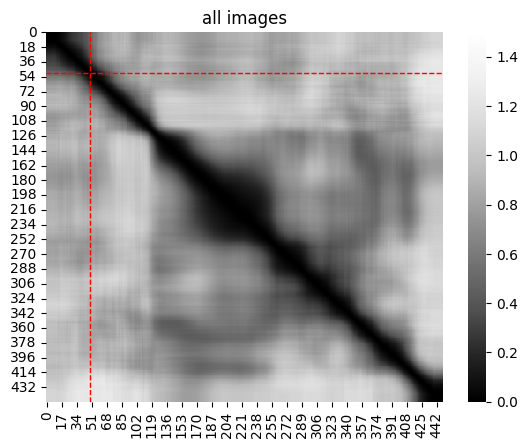

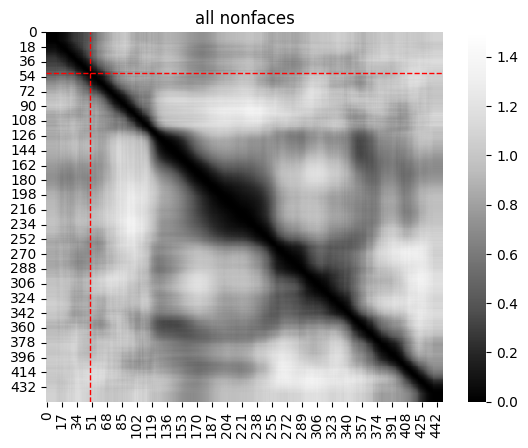

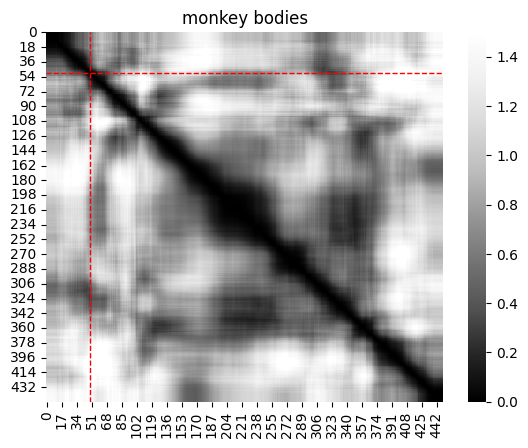

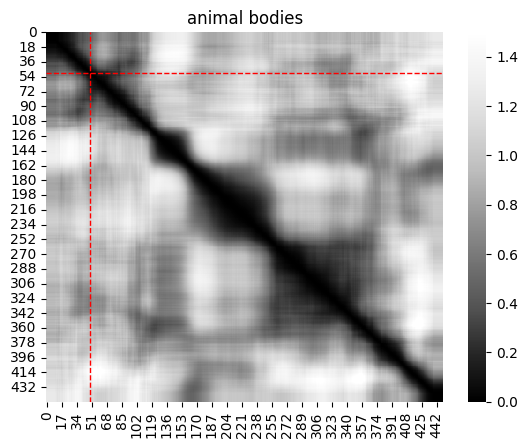

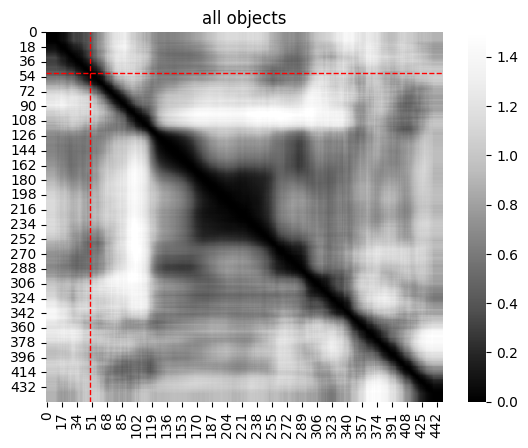

In [37]:
# img_sets = {'all images': np.arange(1000,1072), 
#            'all faces': np.arange(1000,1024),
#            'monkey faces': np.arange(1000,1015),
#            'human faces': np.arange(1015,1024)}

img_sets = {'all images': np.arange(1000,1072), 
           'all nonfaces': np.arange(1025,1072),
           'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
           'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)]))}

metric = 'correlation'
roi = 'AB3_17_B' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])

for k,v in img_sets.items():
    substacked = stacked[:, :, v]
    # average over units
    averaged = np.mean(substacked, axis=0)
    
    fig,ax = plt.subplots(1,1)

    rdm = squareform(pdist(averaged, metric=metric))
    sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=1.5)
    ax.set_title(f'{k}')

    ax.axvline(x=50, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=50, color='red', linestyle='--', linewidth=1)
    plt.show()

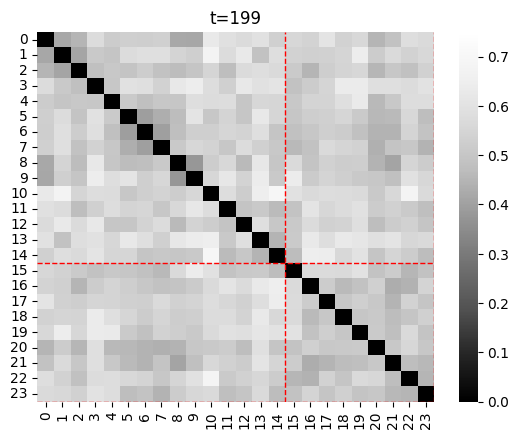

In [8]:
from IPython.display import clear_output
import time

metric = 'correlation'
roi = 'MF1_7_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])

for i in range(200):
    fig, ax = plt.subplots(1,1)
    substacked = stacked[:, i, 1000:1024]
    rdm = squareform(pdist(substacked.T, metric=metric))
    sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=0.75, ax=ax)
    ax.set_title(f't={i}')
    
    ax.axvline(x=15, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=15, color='red', linestyle='--', linewidth=1)
    ax.axvline(x=24, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=24, color='red', linestyle='--', linewidth=1)
    
    plt.show()
    time.sleep(0.01)
    clear_output(wait=True)

In [9]:
savedir = '../gifs/localizer_set/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
metric = 'correlation'
    
roi = 'MF1_7_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])
    
for i in tqdm(range(200)):
    fig, ax = plt.subplots()
    substacked = stacked[:, i, 1000:1024]
    rdm = squareform(pdist(substacked.T, metric=metric))
    sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=0.75, ax=ax)
    ax.set_title(f't={i}')
    plt.tight_layout()
    plt.savefig(os.path.join(savedir,f'frame_{i:03d}.png'), dpi=300, transparent=False, bbox_inches='tight')
    plt.close(fig)
    
print('done')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.57it/s]

done
